# All Spectrogram Code Setup

In [1]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
import pandas as pd

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type="category", ord=None):
    # TODO: Fix the default norm value to be None, and allow other norms to flow through
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    
    # Normalize the trial based on the specified norm type
    if ord is not None:
        print("we are normalizing by rows")
        all_patient_trials = [trials / np.linalg.norm(trials, ord=ord, axis=1, keepdims=True) for trials in all_patient_trials]

    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop=0.5, sample_rows=False):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs = 1e3, window = 'hann', nperseg = 128, noverlap = 96, log_Sxx=False):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def erp_gen_welch(x, fs = 1e3, window = 'hann', nperseg = 128, noverlap = 96):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def specgram_trials(arr_all_trials, fs=1e3, window='hann', nperseg=128, 
                    trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs=1e3, window='hann', nperseg=128, 
                     trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), np.around(x_ticks_l), rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper(base_data_dir, core_cat, trials_type,
                                patient_num, session_idx, tot_num_channels, samp_trial_pop, 
                                ord=None,
                                time_samp_prop=0.2,
                                filter_row_idx=None, 
                                log_Sxx=False,
                                fs=1e3, window='hann', nperseg=128,
                                n_components=8, 
                                init='random', 
                                random_state=0, 
                                beta_loss='itakura-saito', 
                                solver = 'mu',
                                max_iter=400):
    
    # Get all the channels and trials (DONE)
    all_patient_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                                session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                                core_cat=core_cat, trials_type=trials_type, ord=ord)

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H        

# Channel 1 - P41, Faces, Session 1

In [2]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"
ord = 2

### Import all of the trials data for P35, Faces for just channel 1 -  Session 1

In [3]:
# Get all the channels and trials (DONE)
pat_cat_all_ch_tr = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=ord)
pat_cat_all_ch_tr[0].shape

we are normalizing by rows


(84, 1500)

In [4]:
len(pat_cat_all_ch_tr)

85

#### Comments
- This makes sense, just 83 **Face** trials in channel 1 for P35 in session 1.
- Let's extract the first trial only to test out the spectrogram fit.

In [5]:
pat_cat_ch_01_tr_01 = pat_cat_all_ch_tr[0][0]
pat_cat_ch_01_tr_01.shape

(1500,)

In [6]:
pat_cat_ch_01_tr_01

array([-0.03820687, -0.03779474, -0.03673499, ..., -0.03373237,
       -0.0332025 , -0.03143625])

#### Comments

- Good, data extracted for the full 1500 second recording
- Let's normalize the data - we'll use the L2 norm for now

In [7]:
pat_cat_ch_01_tr_01_norm = np.linalg.norm(x=pat_cat_ch_01_tr_01)
pat_cat_ch_01_tr_01_norm
norm_trial = pat_cat_ch_01_tr_01/pat_cat_ch_01_tr_01_norm
np.linalg.norm(x=norm_trial)-np.linalg.norm(x=pat_cat_ch_01_tr_01)

0.0

Seems to be a slight floating point error

In [8]:
# Check that the L2-norm calc is working
test_vec = pat_cat_ch_01_tr_01[0:3]
test_vec
test_vec_norm = np.linalg.norm(x=test_vec)
norm_check = test_vec_norm - np.sqrt(np.sum(test_vec**2))
norm_check
np.linalg.norm(x=test_vec/test_vec_norm)

1.0

### Fit the spectrogram

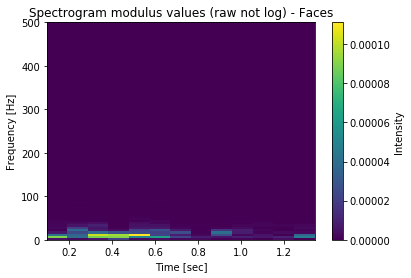

In [9]:
# Fit the spectrogram - no log
f, t, Sxx = erp_gen_spectrogram(x = pat_cat_ch_01_tr_01, fs = 1e3, 
                                window = 'hann', nperseg = 192, noverlap = 96, log_Sxx=False)

# Plot the spectrogram
plt.pcolormesh(t, f, Sxx)
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

In [10]:
Sxx.shape
#t[range(5, 14)]

(97, 14)

### Plot the **log** of the modulus spectrogram values

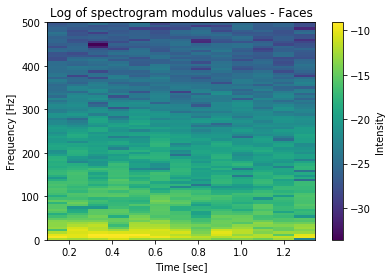

In [11]:
plt.pcolormesh(t, f, np.log(Sxx))
plt.title(f"Log of spectrogram modulus values - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

In [12]:
f[20]
#len(t)
#f

104.16666666666666

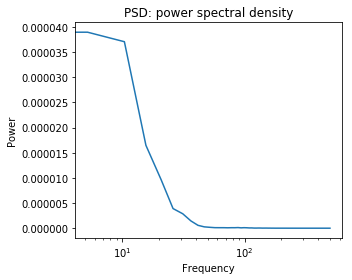

In [13]:
freqs, psd = signal.welch(x = pat_cat_ch_01_tr_01, fs = 1e3, window = 'hann', nperseg = 192, noverlap = 96)

plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [14]:
psd.shape

(97,)

In [4]:
def erp_gen_welch(x, fs = 1e3, window = 'hann', nperseg = 128, noverlap = 96):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def psd_welch_trials(arr_all_trials, fs=1e3, window='hann', nperseg=128, noverlap=96,
                     trials_samp_idx=None, filter_row_idx=None):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_psds = [erp_gen_welch(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)[1] 
                      for idx in all_trial_idx]
        print(trial_psds[0].shape)
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_psds = [erp_gen_welch(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)[1] 
                      for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_psd = np.vstack(trial_psds)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_psd = comb_psd
    else:
        comb_psd = comb_psd[filter_row_idx]
    return comb_psd

def plt_psd_welch_trials(comb_psd, freqs):
    comb_psd_T = comb_psd.T
    num_trials = comb_psd.shape[0]
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_psd = comb_psd
    else:
        comb_psd = comb_psd[filter_row_idx]
    return comb_psd

def plt_psd_welch_trials(comb_psd, freqs):
    comb_psd_T = comb_psd.T
    num_trials = comb_psd.shape[0]
    plt.figure(figsize=(15, 10))
    plt.semilogx(freqs, comb_psd_T[:,range(num_trials)])
    plt.title('PSD: power spectral density')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.tight_layout()
    #plt.legend()

In [6]:
test_psd = psd_welch_trials(arr_all_trials = pat_cat_all_ch_tr[0], fs=1e3, window='hann', nperseg=192, noverlap=96,
                            trials_samp_idx=None, filter_row_idx=None)
test_psd_T = test_psd.T

NameError: name 'pat_cat_all_ch_tr' is not defined

In [17]:
test_psd_T.shape
test_psd.shape

(84, 97)

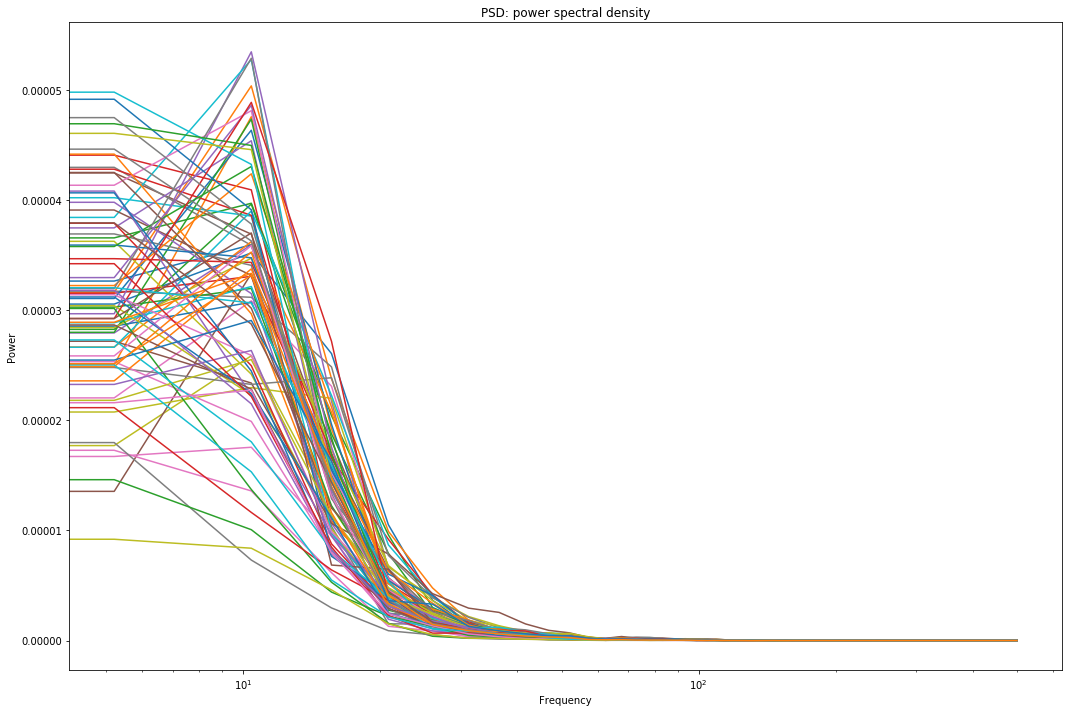

In [18]:
#plt.plot(test_psd_T[:,1:25])
plt.figure(figsize=(15, 10))
plt.semilogx(freqs, test_psd_T[:,1:83])
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

# Wavelet Graph comparison

- Take a single channel - all 83 trials
    - We will do the same for a single trial
- Get all spectrograms for all trials within a single channel (log scale)
    - we will repeat this for the non-log scale
- zscrore the first 500 columns for each row - call the V_PRE (for each spectrogram) **PRE-STIM**
- zscrore the last 1000 columns for each row - call the V_PST (for each spectrogram) **POST-STIM**
- combine V_PRE and V_PST (hstack)
- take the average across all channels

In [19]:
def only_specgram_trials(arr_all_trials, fs=1e3, window='hann', nperseg=128, 
                    trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        trial_specgrams = trial_specgrams
    else:
        trial_specgrams = [specgram[filter_row_idx] for specgram in trial_specgrams]
    return trial_specgrams

In [20]:
def z_score_cols(arr, col_range):
    # Subset array
    sub_arr = arr[:, col_range]
    # Z-score by row the subsetted array
    sub_arr_z = stats.zscore(a=sub_arr, axis=1, ddof=1)
    return sub_arr_z

def zscore_specgram(arr, pre_col_range, pst_col_range):
    pre_arr_z = z_score_cols(arr=arr, col_range=pre_col_range)
    pst_arr_z = z_score_cols(arr=arr, col_range=pst_col_range)
    comb_arr_z = np.hstack([pre_arr_z, pst_arr_z])
    return comb_arr_z

def zscore_specgram_wrapper(arr_all_trials, pre_col_range, pst_col_range, 
                            fs=1e3, window='hann', nperseg=192, 
                            trials_samp_idx=None, filter_row_idx=None, log_Sxx=True):
    
    # Get spectrograms for all of the trials
    specgram_trials = only_specgram_trials(arr_all_trials=arr_all_trials, fs=fs, window=window, nperseg=nperseg, 
                                           trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx, log_Sxx=log_Sxx)

    # Z-score sprectrograms
    z_specgrams = [zscore_specgram(arr=specgram_trial, pre_col_range=pre_col_range, pst_col_range=pst_col_range)
                   for specgram_trial in specgram_trials]
    print(f"the dimension of z_specgrams[0] is {z_specgrams[0].shape}")
    
    comb_z_specgrams = np.dstack(z_specgrams)
    print(f"the dimension of comb_z_specgrams is {comb_z_specgrams.shape}")
    
    # Get mean across corresponding elements of the spectrograms
    mean_z_specgrams = np.mean(z_specgrams, axis=0)
    print(f"the dimension of mean_z_specgrams is {mean_z_specgrams.shape}")
    
    return mean_z_specgrams

In [21]:
# Get all trials for a single channel - P35, Faces, Ch1
pat_cat_all_ch_tr[0]

# Get specgrams for all of the trials
specgram_trials_log = only_specgram_trials(arr_all_trials=pat_cat_all_ch_tr[0], fs=1e3, window='hann', nperseg=192, 
                                           trials_samp_idx=None, filter_row_idx=None, log_Sxx=True)

# Check that we have correctly output the pre-stim
specgram_trials_log[0].shape

#test_pre_z = z_score_cols(arr=specgram_trials_log[0], col_range=range(4))
#test_pre_z

# Get the z-scored PRE/ POST spectrogram for a trial
test_z = zscore_specgram(arr=specgram_trials_log[0], pre_col_range=range(4), pst_col_range=range(4, 14))


In [27]:
test_comb_specgram_log = zscore_specgram_wrapper(arr_all_trials=pat_cat_all_ch_tr[11], pre_col_range=range(4), pst_col_range=range(4, 14), 
                            fs=1e3, window='hann', nperseg=192, 
                            trials_samp_idx=None, filter_row_idx=None, log_Sxx=False)
test_comb_specgram_log.shape

the dimension of z_specgrams[0] is (97, 14)
the dimension of comb_z_specgrams is (97, 14, 84)
the dimension of mean_z_specgrams is (97, 14)


(97, 14)

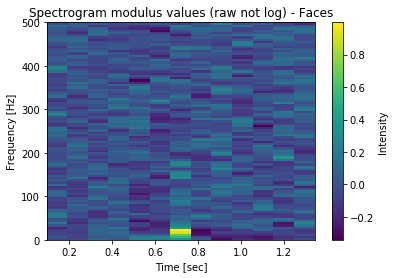

In [28]:
# Plot the spectrogram
plt.pcolormesh(t, f, test_comb_specgram_log)
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

In [24]:
# Get only the first channel recording
pat_cat_all_ch_all_tr_01 = [chnl[4] for chnl in pat_cat_all_ch_tr] # TODO: change the reference here
pat_cat_all_ch_all_tr_01 = np.vstack(pat_cat_all_ch_all_tr_01)
pat_cat_all_ch_all_tr_01.shape
trial_01_comb_specgram_log = zscore_specgram_wrapper(arr_all_trials=pat_cat_all_ch_all_tr_01, pre_col_range=range(4), pst_col_range=range(4, 14), 
                                                     fs=1e3, window='hann', nperseg=192, 
                                                     trials_samp_idx=None, filter_row_idx=None, log_Sxx=True)
trial_01_comb_specgram_log.shape

the dimension of z_specgrams[0] is (97, 14)
the dimension of comb_z_specgrams is (97, 14, 85)
the dimension of mean_z_specgrams is (97, 14)


(97, 14)

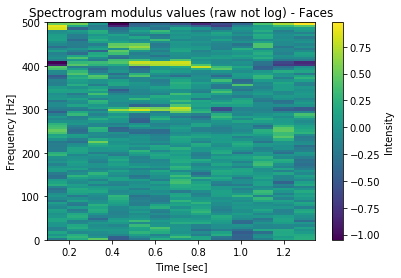

In [25]:
# Plot the spectrogram
plt.pcolormesh(t, f, trial_01_comb_specgram_log)
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

the dimension of z_specgrams[0] is (97, 14)
the dimension of comb_z_specgrams is (97, 14, 85)
the dimension of mean_z_specgrams is (97, 14)


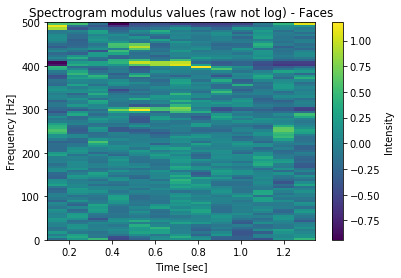

In [26]:
trial_01_comb_specgram = zscore_specgram_wrapper(arr_all_trials=pat_cat_all_ch_all_tr_01, pre_col_range=range(4), pst_col_range=range(4, 14), 
                                                 fs=1e3, window='hann', nperseg=192, 
                                                 trials_samp_idx=None, filter_row_idx=None, log_Sxx=False)
trial_01_comb_specgram.shape
plt.pcolormesh(t, f, trial_01_comb_specgram)
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

# 85 Channels - P35, Faces, Session 1

### Perform NMF for P35 - 85 Channels, Faces, Session 1 
#### (100% sampling of trials, 20% sampling of time)

In [32]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 35
tot_num_channels = list(range(85))
trials_type = "category"
ord = 2 # 2-norm
session_idx = 1
core_cat = "Faces"
filter_row_idx=range(21)
fs = 1e3
window = 'hann'
nperseg = 192

In [33]:
V, W, H = entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=1.0, # 100% sampling of trials
                                      time_samp_prop=1.0, # 100% sampling of time)
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg,
                                      log_Sxx=False,
                                      n_components=8, 
                                      init='random', 
                                      random_state=0, 
                                      beta_loss='itakura-saito', 
                                      solver = 'mu',
                                      max_iter=400)

we are normalizing by rows
83
comb_all_channels_specgrams: (21, 98770)
time_samp_idx length: 98770
comb_specgram_time_sample: (21, 98770)
STARTING NMF...
V: (21, 98770)
W: (21, 8)
H: (8, 98770)
NMF COMPLETE!


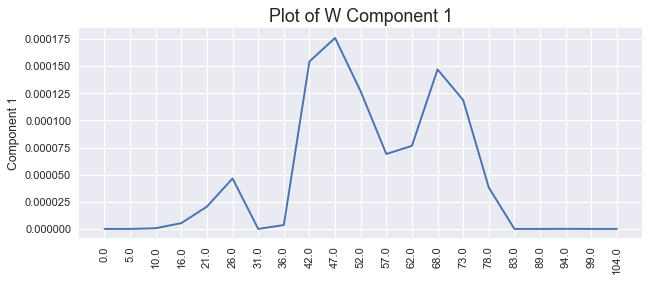

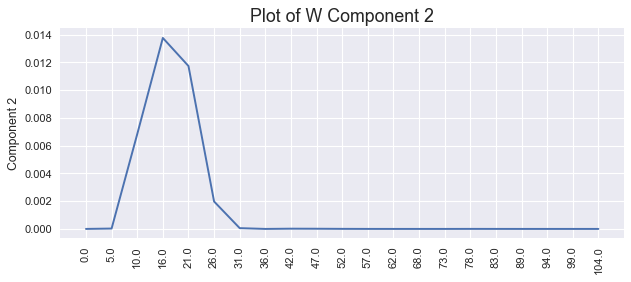

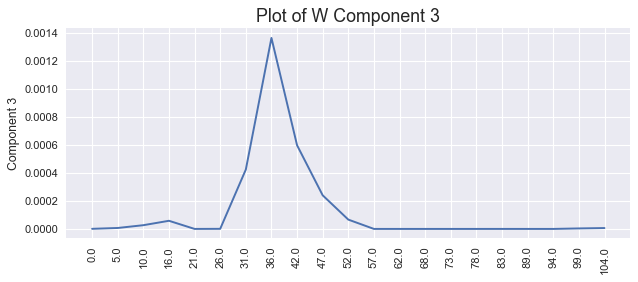

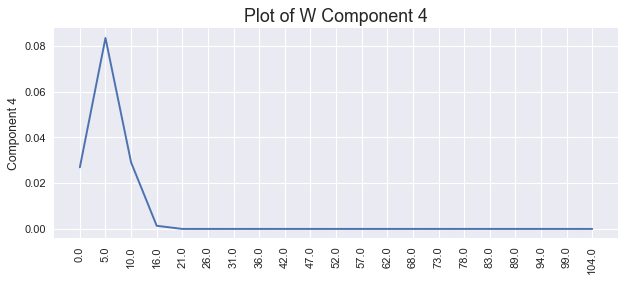

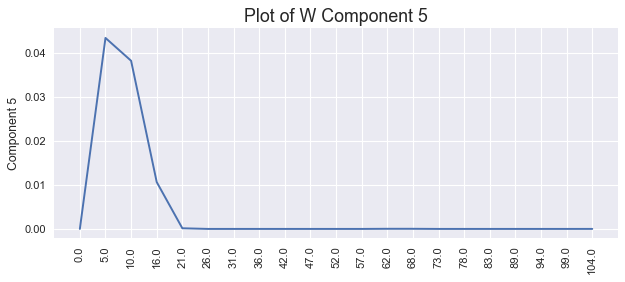

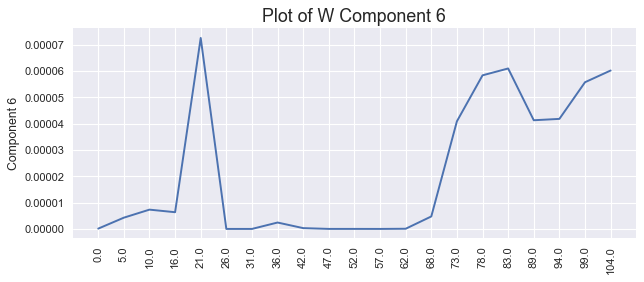

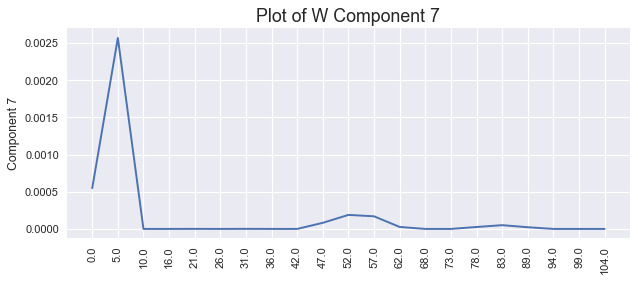

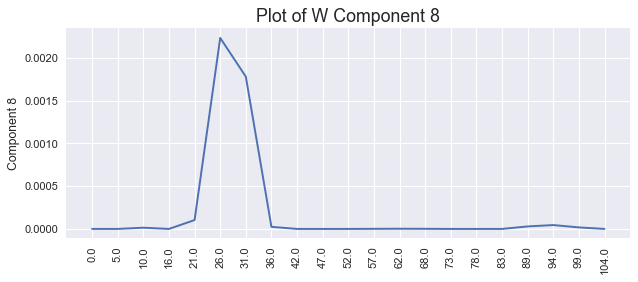

In [36]:
#freq_ticks = np.around(np.linspace(0, 100, num=len(filter_row_idx)), decimals=0)
freq_ticks = f[filter_row_idx]
#freq_ticks
plotW(W = W, log=False, x_ticks_l=freq_ticks)

98770


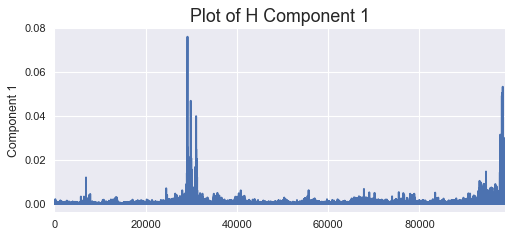

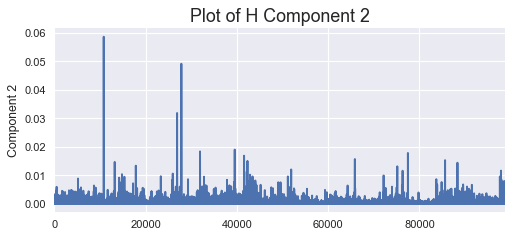

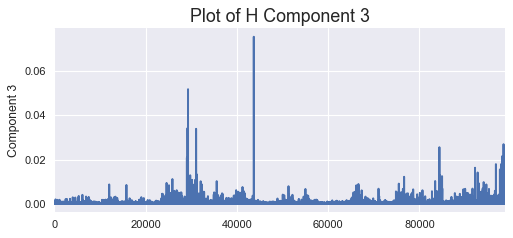

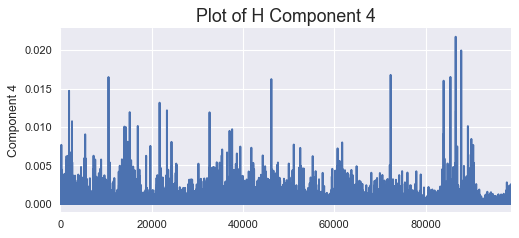

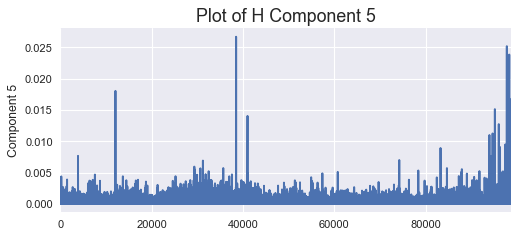

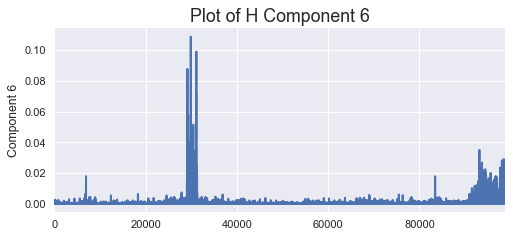

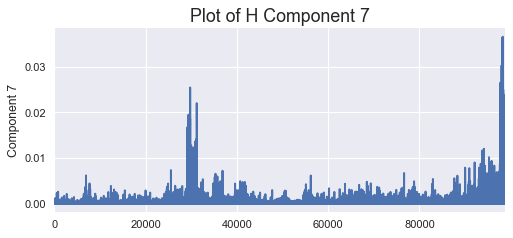

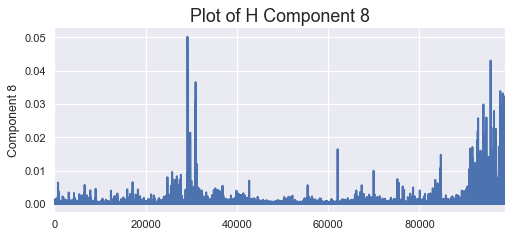

In [37]:
plotH(H = H, log=False, y_ticks_l=None)

In [48]:
num_reps = 20
results_NMF = [entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=0.9, # 70% sampling of trials
                                      time_samp_prop=1.0, # 20% sampling of time)
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg,
                                      log_Sxx=False,
                                      n_components=8, 
                                      init='random', 
                                      random_state=0, 
                                      beta_loss='itakura-saito', 
                                      solver = 'mu',
                                      max_iter=400) for i in range(num_reps)]

we are normalizing by rows
74
comb_all_channels_specgrams: (21, 88060)
time_samp_idx length: 88060
comb_specgram_time_sample: (21, 88060)
STARTING NMF...
V: (21, 88060)
W: (21, 8)
H: (8, 88060)
NMF COMPLETE!
we are normalizing by rows
74
comb_all_channels_specgrams: (21, 88060)
time_samp_idx length: 88060
comb_specgram_time_sample: (21, 88060)
STARTING NMF...
V: (21, 88060)
W: (21, 8)
H: (8, 88060)
NMF COMPLETE!
we are normalizing by rows
74
comb_all_channels_specgrams: (21, 88060)
time_samp_idx length: 88060
comb_specgram_time_sample: (21, 88060)
STARTING NMF...
V: (21, 88060)
W: (21, 8)
H: (8, 88060)
NMF COMPLETE!
we are normalizing by rows
74
comb_all_channels_specgrams: (21, 88060)
time_samp_idx length: 88060
comb_specgram_time_sample: (21, 88060)
STARTING NMF...
V: (21, 88060)
W: (21, 8)
H: (8, 88060)
NMF COMPLETE!
we are normalizing by rows
74
comb_all_channels_specgrams: (21, 88060)
time_samp_idx length: 88060
comb_specgram_time_sample: (21, 88060)
STARTING NMF...
V: (21, 88060)

### Create the tensor of all the $W$ matrices

In [49]:
W_mats = [results_NMF[i][1] for i in range(len(results_NMF))]
W_tens = np.dstack(tup=W_mats)
W_tens.shape
W_tens[:, 0, :].shape
len(W_mats)
#W_mats[9].shape

20

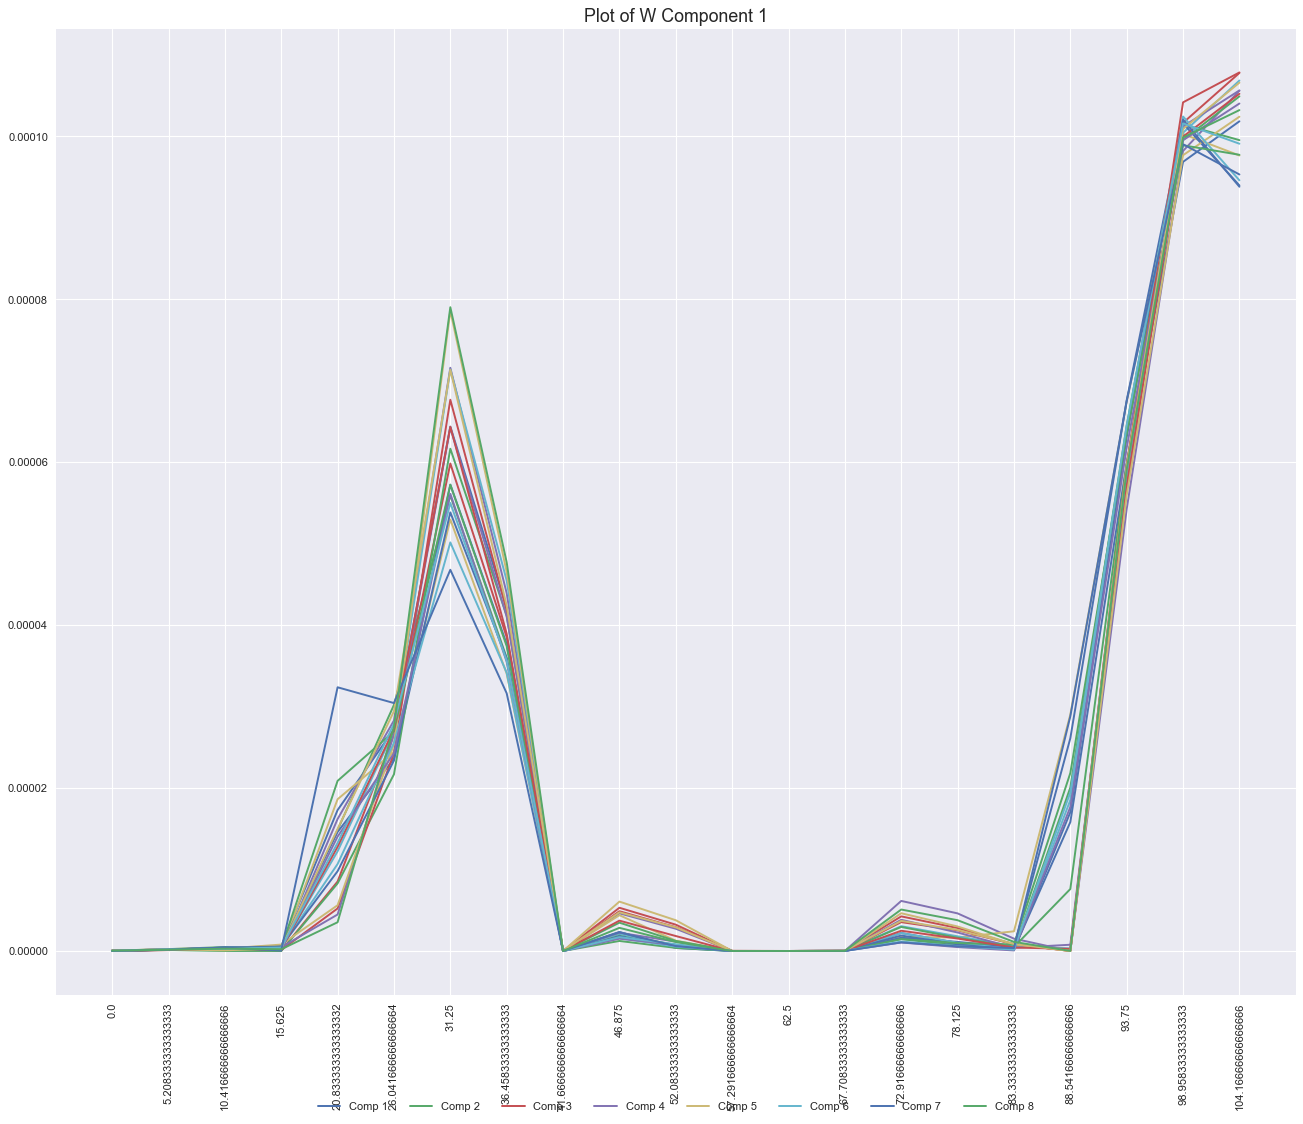

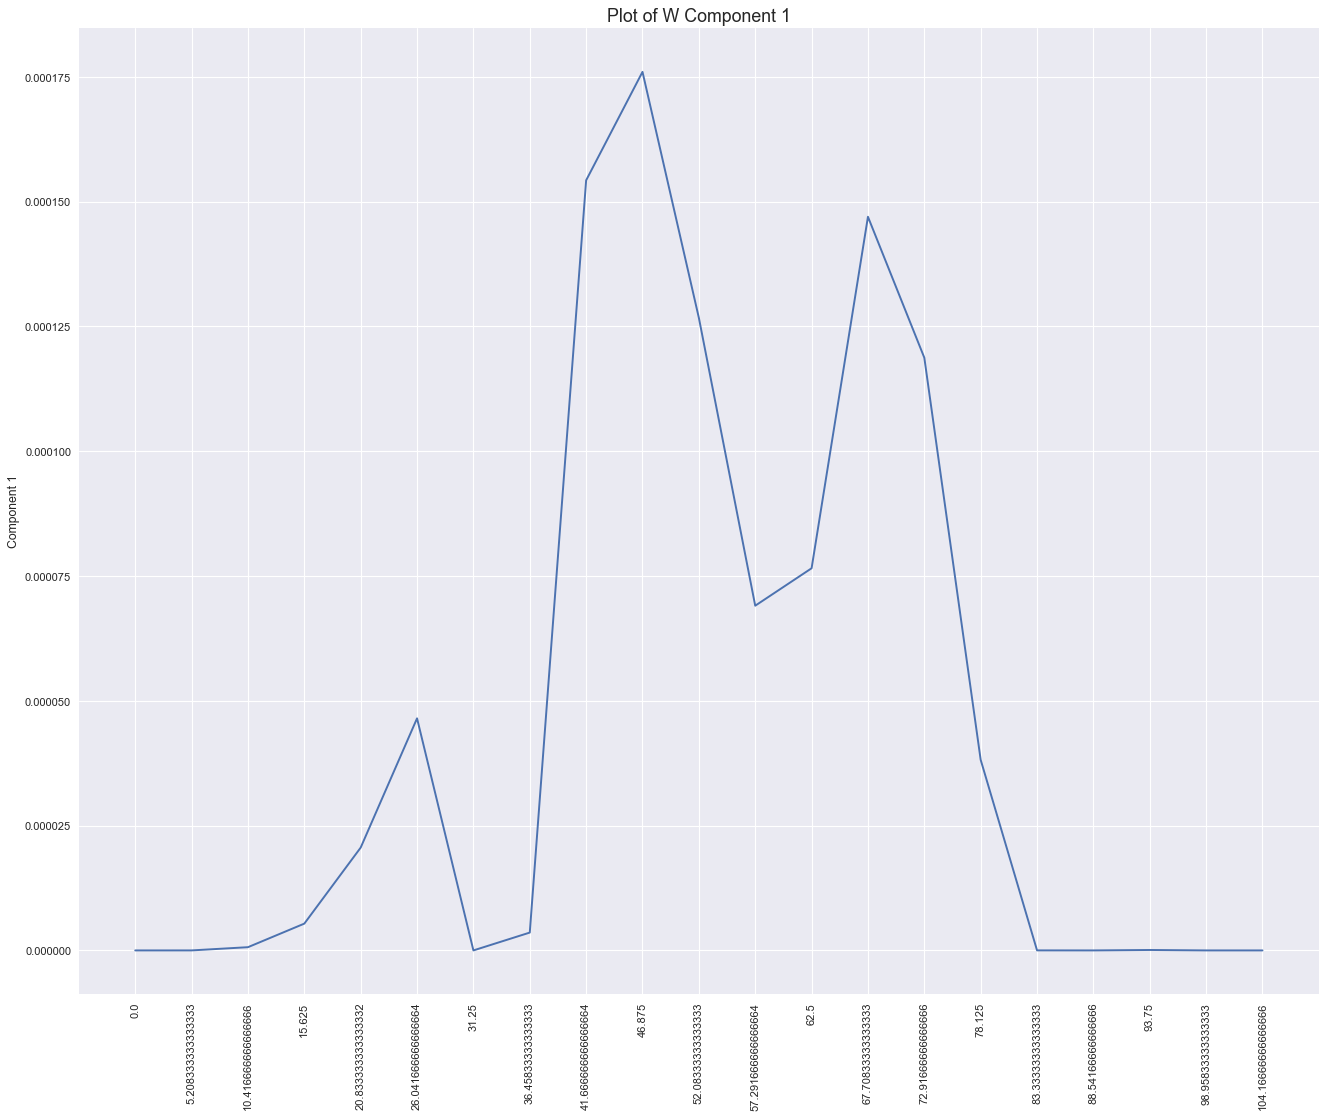

In [50]:
def repl_check_W(W_tens, W_all_trials, component, x_ticks_l):
    plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
    num_replicates = W_tens.shape[1]
    plt.title(f'Plot of W Component {component + 1}', fontsize=16)    
    legend_names = [f'Comp {n + 1}' for n in range(num_replicates)]    
    plt.plot(W_tens[:, component, :])
    plt.xticks(range(0, W_all_trials.shape[0]), x_ticks_l, rotation='vertical')
    plt.legend(legend_names, loc=9, bbox_to_anchor=(0.5, -0.1), ncol = 10)
    plt.show()   
    
    plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(W_all_trials[:, component])
    plt.title(f'Plot of W Component {component + 1}', fontsize=16)    
    plt.xticks(range(0, W_all_trials.shape[0]), x_ticks_l, rotation='vertical')
    plt.ylabel(f'Component {component + 1}')
    plt.show()

repl_check_W(W_tens=W_tens, W_all_trials=W, component=0, x_ticks_l=freq_ticks)

### Replicate NMF 20 times 
#### (100% sampling of trials, 20% sampling of time)

In [20]:
num_reps = 20
results_NMF1 = [entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=1.0, # 100% sampling of trials
                                      time_samp_prop=1.0, # 20% sampling of time)
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg,
                                      log_Sxx=False,
                                      n_components=8, 
                                      init='random', 
                                      random_state=0, 
                                      beta_loss='itakura-saito', 
                                      solver = 'mu',
                                      max_iter=400) for i in range(num_reps)]

we are normalizing by rows
83
comb_all_channels_specgrams: (27, 56440)
time_samp_idx length: 56440
comb_specgram_time_sample: (27, 56440)
STARTING NMF...
V: (27, 56440)
W: (27, 8)
H: (8, 56440)
NMF COMPLETE!
we are normalizing by rows
83
comb_all_channels_specgrams: (27, 56440)
time_samp_idx length: 56440
comb_specgram_time_sample: (27, 56440)
STARTING NMF...
V: (27, 56440)
W: (27, 8)
H: (8, 56440)
NMF COMPLETE!
we are normalizing by rows
83
comb_all_channels_specgrams: (27, 56440)
time_samp_idx length: 56440
comb_specgram_time_sample: (27, 56440)
STARTING NMF...
V: (27, 56440)
W: (27, 8)
H: (8, 56440)
NMF COMPLETE!
we are normalizing by rows
83
comb_all_channels_specgrams: (27, 56440)
time_samp_idx length: 56440
comb_specgram_time_sample: (27, 56440)
STARTING NMF...
V: (27, 56440)
W: (27, 8)
H: (8, 56440)
NMF COMPLETE!
we are normalizing by rows
83
comb_all_channels_specgrams: (27, 56440)
time_samp_idx length: 56440
comb_specgram_time_sample: (27, 56440)
STARTING NMF...
V: (27, 56440)

In [21]:
#results_NMF1 = results_NMF
W_mats1 = [results_NMF1[i][1] for i in range(len(results_NMF1))]
W_tens1 = np.dstack(tup=W_mats1)
W_tens1.shape
W_tens1[:, 0, :].shape
#len(W_mats)
#W_mats[9].shape

(27, 20)

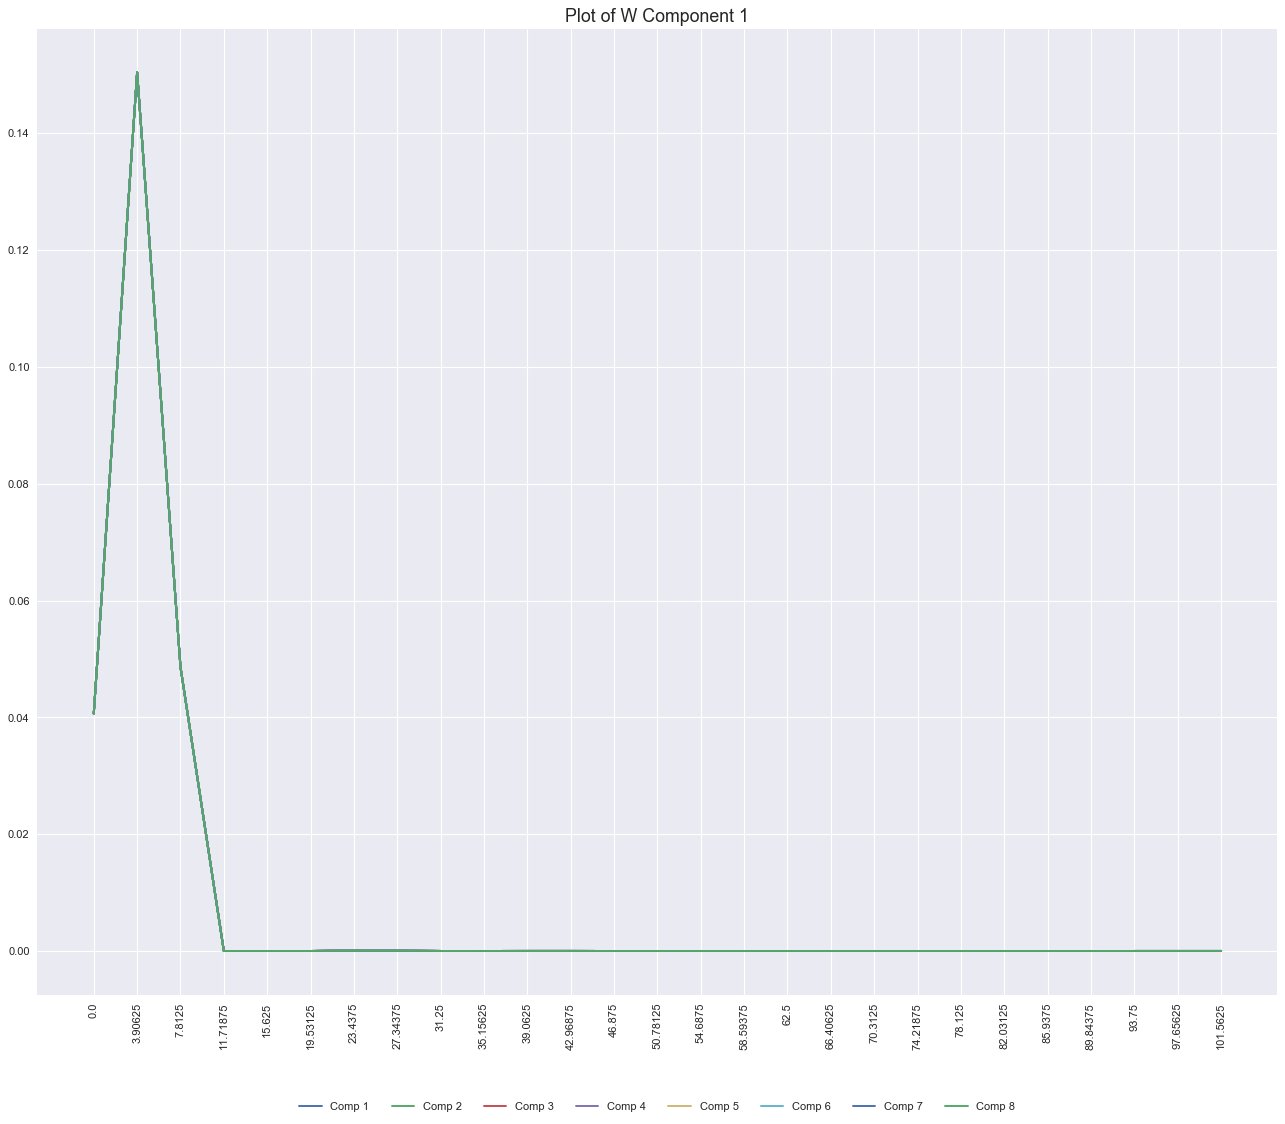

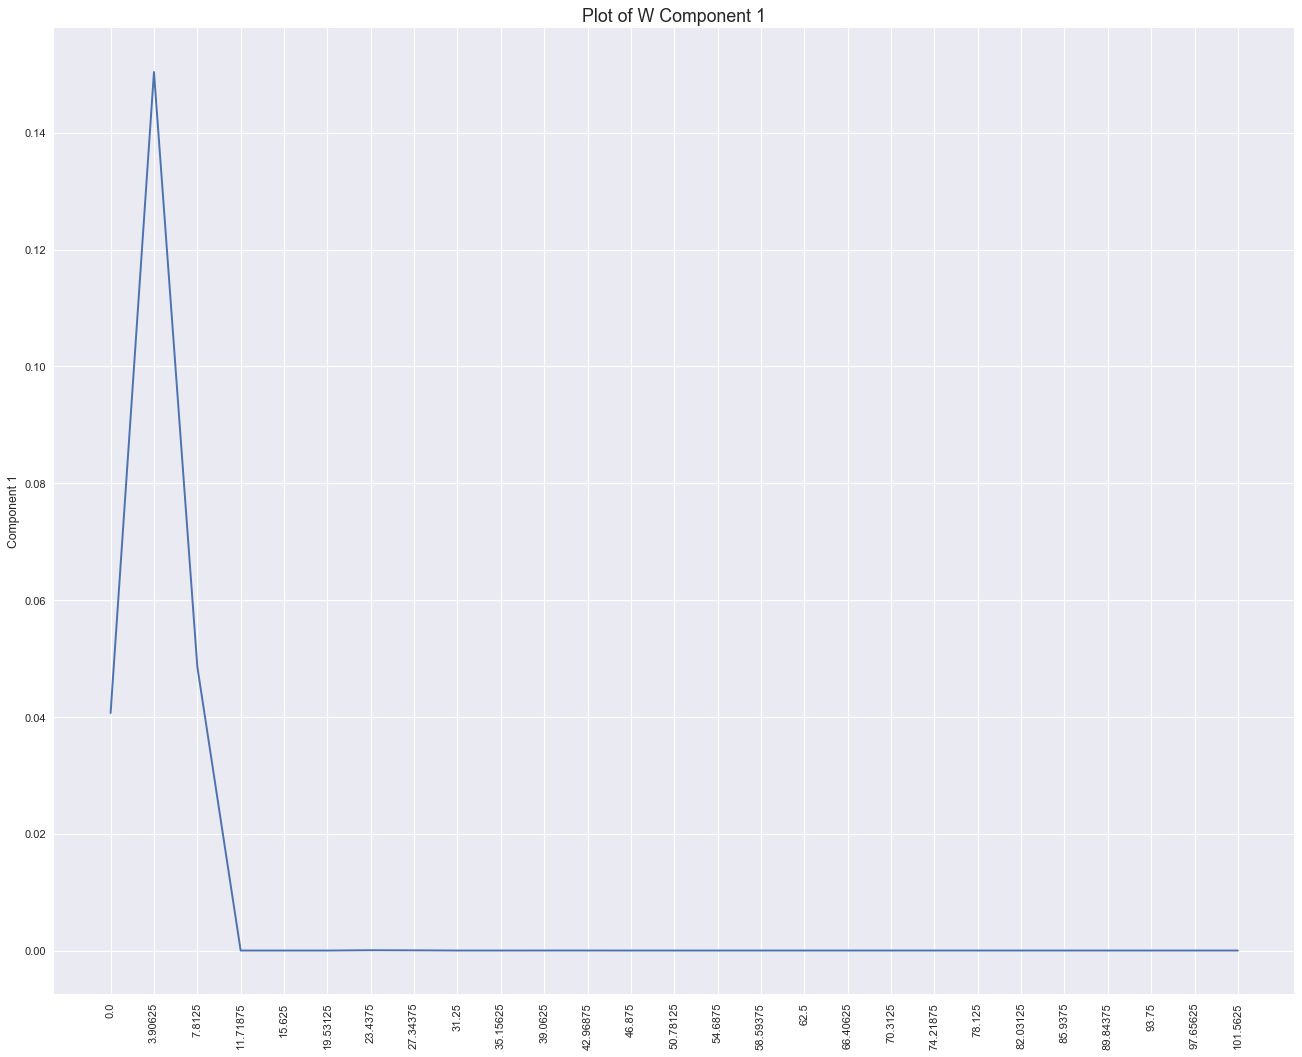

In [22]:
repl_check_W(W_tens=W_tens1, W_all_trials=W, component=0, x_ticks_l=freq_ticks)

## New tasks - for Discussion
- How many frequency bands to choose? Is 8 reasonable, can we select these in a more principled way?
- What are the highest observed frequencies in the brain at which something interesting is observed to occur?
- Check stability when trials are sampled and how to deal with this?
- Combine sessions for a single patient
- Combine patients at some point?
- Consider the time lag in the ERP signal?
- AG: Taper - wavelet basis. Different frequencies
- AG: Sample equally in frequencies and time